In [2]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12.0, 6.0)

import numpy as np
import math
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

Using TensorFlow backend.


In [3]:
from bokeh.plotting import output_file, show, figure
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [107]:
dataset = pd.read_csv('724940_all.csv')
dataset.head()

,YYYY-MM-DD,HH:MM (LST),Zenith (deg),Azimuth (deg),ETR (W/m^2),ETRN (W/m^2),Glo Mod (W/m^2),Glo Mod Unc (%),Glo Mod Source,Dir Mod (W/m^2),Dir Mod Unc (%),Dir Mod Source,Dif Mod (W/m^2),Dif Mod Unc (%),Dif Mod Source,Meas Glo (W/m^2),Meas Glo Flg,Meas Dir (W/m^2),Meas Dir Flg,Meas Dif (W/m^2),Meas Dif Flg,TotCC (10ths),Precip Wat (cm),Precip Wat Flg,AOD (unitless),AOD Flg
0,1991-01-01,1:00,99.00000,-99.00000,0,0,0,0,1,0,0,1,0,0,1,-9900,99,-9900,99,-9900,99,6,0.70000,1,0.10800,1
1,1991-01-01,2:00,99.00000,-99.00000,0,0,0,0,1,0,0,1,0,0,1,-9900,99,-9900,99,-9900,99,10,0.70000,1,0.10800,1
2,1991-01-01,3:00,99.00000,-99.00000,0,0,0,0,1,0,0,1,0,0,1,-9900,99,-9900,99,-9900,99,10,0.80000,1,0.10800,1
3,1991-01-01,4:00,99.00000,-99.00000,0,0,0,0,1,0,0,1,0,0,1,-9900,99,-9900,99,-9900,99,10,0.80000,1,0.10800,1
4,1991-01-01,5:00,99.00000,-99.00000,0,0,0,0,1,0,0,1,0,0,1,-9900,99,-9900,99,-9900,99,10,0.80000,1,0.10800,1


In [108]:
dataset.loc[0, :]

YYYY-MM-DD          1991-01-01
HH:MM (LST)               1:00
Zenith (deg)          99.00000
Azimuth (deg)        -99.00000
ETR (W/m^2)                  0
ETRN (W/m^2)                 0
Glo Mod (W/m^2)              0
Glo Mod Unc (%)              0
Glo Mod Source               1
Dir Mod (W/m^2)              0
Dir Mod Unc (%)              0
Dir Mod Source               1
Dif Mod  (W/m^2)             0
Dif Mod Unc (%)              0
Dif Mod Source               1
Meas Glo (W/m^2)         -9900
Meas Glo Flg                99
Meas Dir (W/m^2)         -9900
Meas Dir Flg                99
Meas Dif (W/m^2)         -9900
Meas Dif Flg                99
TotCC (10ths)                6
Precip Wat (cm)        0.70000
Precip Wat Flg               1
AOD (unitless)         0.10800
AOD Flg                      1
Name: 0, dtype: object

## Preprocess dataframe and select the features

In [109]:
# To preprocess the data frame and caculate the GHI
def preprocess(df):
    # Select columns
    df = df.loc[:, ['YYYY-MM-DD', 'HH:MM (LST)', 'Zenith (deg)', 'Dir Mod (W/m^2)', \
                    'Dif Mod  (W/m^2)', 'Meas Dir (W/m^2)', 'Meas Dif (W/m^2)',
                    'Precip Wat (cm)', 'AOD (unitless)']]
    
    # Convert degree to radian
    df['Zenith (deg)'] = df['Zenith (deg)'].apply(math.radians)
    df = df.rename({'Zenith (deg)': 'Zenith (rad)'}, axis = 1)
    
    # Calculate GHI
    df['GHI'] = df['Dif Mod  (W/m^2)'].astype('float') + \
                df['Dir Mod (W/m^2)']. astype('float') * df['Zenith (rad)'].apply(math.cos)

    return df

In [110]:
dataset_post = preprocess(dataset)
dataset_post.head()

,YYYY-MM-DD,HH:MM (LST),Zenith (rad),Dir Mod (W/m^2),Dif Mod (W/m^2),Meas Dir (W/m^2),Meas Dif (W/m^2),Precip Wat (cm),AOD (unitless),GHI
0,1991-01-01,1:00,1.72788,0,0,-9900,-9900,0.70000,0.10800,0.00000
1,1991-01-01,2:00,1.72788,0,0,-9900,-9900,0.70000,0.10800,0.00000
2,1991-01-01,3:00,1.72788,0,0,-9900,-9900,0.80000,0.10800,0.00000
3,1991-01-01,4:00,1.72788,0,0,-9900,-9900,0.80000,0.10800,0.00000
4,1991-01-01,5:00,1.72788,0,0,-9900,-9900,0.80000,0.10800,0.00000


In [111]:
dataset_post.tail()

,YYYY-MM-DD,HH:MM (LST),Zenith (rad),Dir Mod (W/m^2),Dif Mod (W/m^2),Meas Dir (W/m^2),Meas Dif (W/m^2),Precip Wat (cm),AOD (unitless),GHI
131491,2005-12-31,20:00,1.72788,0,0,-9900,-9900,2.00000,0.04900,0.00000
131492,2005-12-31,21:00,1.72788,0,0,-9900,-9900,2.00000,0.04900,0.00000
131493,2005-12-31,22:00,1.72788,0,0,-9900,-9900,2.00000,0.04900,0.00000
131494,2005-12-31,23:00,1.72788,0,0,-9900,-9900,2.00000,0.04900,0.00000
131495,2005-12-31,24:00,1.72788,0,0,-9900,-9900,2.00000,0.04900,0.00000


In [112]:
dataset_post['YYYY-MM-DD'] = pd.to_datetime(dataset_post['YYYY-MM-DD'])  
dataset_post = dataset_post.rename({'YYYY-MM-DD':'Datetime'}, axis = 1)
dataset_post.head()

,Datetime,HH:MM (LST),Zenith (rad),Dir Mod (W/m^2),Dif Mod (W/m^2),Meas Dir (W/m^2),Meas Dif (W/m^2),Precip Wat (cm),AOD (unitless),GHI
0,1991-01-01,1:00,1.72788,0,0,-9900,-9900,0.70000,0.10800,0.00000
1,1991-01-01,2:00,1.72788,0,0,-9900,-9900,0.70000,0.10800,0.00000
2,1991-01-01,3:00,1.72788,0,0,-9900,-9900,0.80000,0.10800,0.00000
3,1991-01-01,4:00,1.72788,0,0,-9900,-9900,0.80000,0.10800,0.00000
4,1991-01-01,5:00,1.72788,0,0,-9900,-9900,0.80000,0.10800,0.00000


In [113]:
daily = dataset_post.groupby('Datetime')
daily_data = daily['Datetime', 'GHI', 'Precip Wat (cm)', 'AOD (unitless)'].mean()

In [114]:
daily_data.head()

,GHI,Precip Wat (cm),AOD (unitless)
Datetime,,,
1991-01-01,95.99922,0.82500,0.10233
1991-01-02,79.88263,1.00000,0.10283
1991-01-03,66.10387,1.15417,0.09408
1991-01-04,104.28998,1.11250,0.08858
1991-01-05,92.72703,1.00000,0.13192


In [115]:
daily_data = daily_data.rename({'Precip Wat (cm)':'Precip_water', 'AOD (unitless)':'AOD'}, axis = 1)
daily_data.head()

,GHI,Precip_water,AOD
Datetime,,,
1991-01-01,95.99922,0.82500,0.10233
1991-01-02,79.88263,1.00000,0.10283
1991-01-03,66.10387,1.15417,0.09408
1991-01-04,104.28998,1.11250,0.08858
1991-01-05,92.72703,1.00000,0.13192


In [116]:
daily_data.index

DatetimeIndex(['1991-01-01', '1991-01-02', '1991-01-03', '1991-01-04',
               '1991-01-05', '1991-01-06', '1991-01-07', '1991-01-08',
               '1991-01-09', '1991-01-10',
               ...
               '2005-12-22', '2005-12-23', '2005-12-24', '2005-12-25',
               '2005-12-26', '2005-12-27', '2005-12-28', '2005-12-29',
               '2005-12-30', '2005-12-31'],
              dtype='datetime64[ns]', name=u'Datetime', length=5479, freq=None)

In [117]:
weekly_ts = daily_data.resample('W').mean()
weekly_ts.head()

,GHI,Precip_water,AOD
Datetime,,,
1991-01-06,85.09763,1.05972,0.10360
1991-01-13,58.80077,1.89464,0.09291
1991-01-20,104.41089,1.18393,0.10782
1991-01-27,124.74611,0.91131,0.09242
1991-02-03,110.09800,1.31786,0.11607


### Use month as a feature

In [118]:
weekly_ts.index[100].month

12

In [119]:
weekly_ts['Month'] = weekly_ts.index.month

In [120]:
weekly_ts.head()

,GHI,Precip_water,AOD,Month
Datetime,,,,
1991-01-06,85.09763,1.05972,0.10360,1
1991-01-13,58.80077,1.89464,0.09291,1
1991-01-20,104.41089,1.18393,0.10782,1
1991-01-27,124.74611,0.91131,0.09242,1
1991-02-03,110.09800,1.31786,0.11607,2


In [121]:
weekly_ts = weekly_ts.loc['1995':'2005']

In [122]:
weekly_ts.head()

,GHI,Precip_water,AOD,Month
Datetime,,,,
1995-01-01,77.89531,1.46786,0.08713,1
1995-01-08,52.94224,1.88393,0.08758,1
1995-01-15,53.55987,2.22024,0.14420,1
1995-01-22,78.64368,1.40000,0.13220,1
1995-01-29,68.49912,2.09524,0.13599,1


In [123]:
p = figure(width=800, height=350, x_axis_type="datetime")

# add renderers
p.line(weekly_ts.index, weekly_ts.GHI, color='navy', legend='GHI')
show(p)

In [124]:
p = figure(width=800, height=350, x_axis_type="datetime")

# add renderers
p.line(weekly_ts.index, weekly_ts.Precip_water, color='navy', legend='Precip Water')
show(p)

In [125]:
p = figure(width=800, height=350, x_axis_type="datetime")

# add renderers
p.line(weekly_ts.index, weekly_ts.AOD, color='navy', legend='Precip Water')
show(p)

### Add previous 5 lags of GHI as feature

In [126]:
for lags in range(1,6):
    weekly_ts["T_" + str(lags)] = weekly_ts.GHI.shift(lags)

In [127]:
weekly_ts.fillna(0.00,inplace=True)
weekly_ts.head(10)

,GHI,Precip_water,AOD,Month,T_1,T_2,T_3,T_4,T_5
Datetime,,,,,,,,,
1995-01-01,77.89531,1.46786,0.08713,1,0.00000,0.00000,0.00000,0.00000,0.00000
1995-01-08,52.94224,1.88393,0.08758,1,77.89531,0.00000,0.00000,0.00000,0.00000
1995-01-15,53.55987,2.22024,0.14420,1,52.94224,77.89531,0.00000,0.00000,0.00000
1995-01-22,78.64368,1.40000,0.13220,1,53.55987,52.94224,77.89531,0.00000,0.00000
1995-01-29,68.49912,2.09524,0.13599,1,78.64368,53.55987,52.94224,77.89531,0.00000
1995-02-05,100.49330,1.96786,0.10988,2,68.49912,78.64368,53.55987,52.94224,77.89531
1995-02-12,94.11305,1.37619,0.14674,2,100.49330,68.49912,78.64368,53.55987,52.94224
1995-02-19,142.49243,1.22679,0.16978,2,94.11305,100.49330,68.49912,78.64368,53.55987
1995-02-26,123.31097,1.28214,0.07993,2,142.49243,94.11305,100.49330,68.49912,78.64368


## Build model without removing seasonality

In [203]:
weekly_ts.index[52*3 + 1]

Timestamp('1998-01-04 00:00:00', freq='W-SUN')

In [133]:
weekly_ts.tail(53)

,GHI,Precip_water,AOD,Month,T_1,T_2,T_3,T_4,T_5
Datetime,,,,,,,,,
2004-12-26,86.12898,1.04940,0.10800,12,95.93684,66.89699,109.08372,106.34229,113.23269
2005-01-02,49.44721,1.58929,0.10800,1,86.12898,95.93684,66.89699,109.08372,106.34229
2005-01-09,61.90325,1.46190,0.10800,1,49.44721,86.12898,95.93684,66.89699,109.08372
2005-01-16,110.09291,1.30476,0.10914,1,61.90325,49.44721,86.12898,95.93684,66.89699
2005-01-23,116.00597,1.44881,0.11057,1,110.09291,61.90325,49.44721,86.12898,95.93684
2005-01-30,104.46748,1.70238,0.11229,1,116.00597,110.09291,61.90325,49.44721,86.12898
2005-02-06,140.99710,1.23869,0.11457,2,104.46748,116.00597,110.09291,61.90325,49.44721
2005-02-13,107.34233,1.70238,0.11771,2,140.99710,104.46748,116.00597,110.09291,61.90325
2005-02-20,59.20883,2.09107,0.12200,2,107.34233,140.99710,104.46748,116.00597,110.09291


In [204]:
training_data = weekly_ts.loc['1998-01-04':'2004-12-31']
test_data = weekly_ts.loc['2005-01-01':]

In [205]:
training_data.tail(3)

,GHI,Precip_water,AOD,Month,T_1,T_2,T_3,T_4,T_5
Datetime,,,,,,,,,
2004-12-12,66.89699,2.06071,0.10943,12,109.08372,106.34229,113.23269,81.62922,119.45598
2004-12-19,95.93684,1.21131,0.10843,12,66.89699,109.08372,106.34229,113.23269,81.62922
2004-12-26,86.12898,1.04940,0.10800,12,95.93684,66.89699,109.08372,106.34229,113.23269


In [206]:
test_data.head(3)

,GHI,Precip_water,AOD,Month,T_1,T_2,T_3,T_4,T_5
Datetime,,,,,,,,,
2005-01-02,49.44721,1.58929,0.10800,1,86.12898,95.93684,66.89699,109.08372,106.34229
2005-01-09,61.90325,1.46190,0.10800,1,49.44721,86.12898,95.93684,66.89699,109.08372
2005-01-16,110.09291,1.30476,0.10914,1,61.90325,49.44721,86.12898,95.93684,66.89699


### Random forest regressor model

In [207]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score,mean_squared_error

In [208]:
X_train,y_train = training_data.drop(['GHI'], axis=1), training_data.GHI
X_test,y_test = test_data.drop(['GHI'], axis=1),test_data.GHI

In [209]:
print "train shape:", X_train.shape, y_train.shape
print "test shape:", X_test.shape, y_test.shape

train shape: (365, 8) (365,)
test shape: (52, 8) (52,)


In [210]:
#scaler = StandardScaler()
scaler = MinMaxScaler(feature_range=(-1, 1))
rfr  = RandomForestRegressor(random_state=2017,verbose=2,n_jobs=5)

#### Normalize features

In [211]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [212]:
rfr.fit(X_train_scaled, y_train)

building tree 1 of 10building tree 2 of 10
building tree 3 of 10building tree 4 of 10


 building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=5)]: Done   7 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:    0.1s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=5,
           oob_score=False, random_state=2017, verbose=2, warm_start=False)

In [213]:
rfr.score(X_test ,y_test)

[Parallel(n_jobs=5)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:    0.0s finished


0.012269656618867253

In [214]:
test_data["RF_PREDICTED"] = rfr.predict(X_test_scaled)

[Parallel(n_jobs=5)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:    0.0s finished
/Users/qianyu/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [215]:
test_data.head(5)

,GHI,Precip_water,AOD,Month,T_1,T_2,T_3,T_4,T_5,RF_PREDICTED
Datetime,,,,,,,,,,
2005-01-02,49.44721,1.58929,0.10800,1,86.12898,95.93684,66.89699,109.08372,106.34229,88.37066
2005-01-09,61.90325,1.46190,0.10800,1,49.44721,86.12898,95.93684,66.89699,109.08372,88.42723
2005-01-16,110.09291,1.30476,0.10914,1,61.90325,49.44721,86.12898,95.93684,66.89699,97.57058
2005-01-23,116.00597,1.44881,0.11057,1,110.09291,61.90325,49.44721,86.12898,95.93684,110.10964
2005-01-30,104.46748,1.70238,0.11229,1,116.00597,110.09291,61.90325,49.44721,86.12898,84.05093


In [216]:
predict_p = figure(width=900, height=350, x_axis_type="datetime")

# add renderers
predict_p.line(test_data.index, y=test_data.GHI, color = 'blue', legend='Test Data')
predict_p.line(test_data.index, y=test_data.RF_PREDICTED, color = 'red', legend='Predict')
show(predict_p)

###  Use Root Mean Square Error to measure the model accuracy

In [217]:
RMSE = np.sqrt(mean_squared_error(test_data.GHI, test_data.RF_PREDICTED))
print "Random Forrest Regressor Model RMSE : {:.5f}".format(RMSE)

Random Forrest Regressor Model RMSE : 35.34083


### LSTM Model

In [218]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, 8)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

#### Reshape data into 3-D

In [219]:
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

In [226]:
hist = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 1s - loss: 28569.5282
Epoch 2/100
 - 1s - loss: 28158.8021
Epoch 3/100
 - 1s - loss: 27760.3538
Epoch 4/100
 - 1s - loss: 27371.4106
Epoch 5/100
 - 2s - loss: 26990.9224
Epoch 6/100
 - 2s - loss: 26616.5105
Epoch 7/100
 - 1s - loss: 26247.7919
Epoch 8/100
 - 1s - loss: 25884.0197
Epoch 9/100
 - 2s - loss: 25525.2155
Epoch 10/100
 - 3s - loss: 25172.0461
Epoch 11/100
 - 2s - loss: 24821.7780
Epoch 12/100
 - 2s - loss: 24474.9625
Epoch 13/100
 - 2s - loss: 24133.1485
Epoch 14/100
 - 2s - loss: 23795.1670
Epoch 15/100
 - 2s - loss: 23461.8426
Epoch 16/100
 - 2s - loss: 23132.6488
Epoch 17/100
 - 3s - loss: 22806.5964
Epoch 18/100
 - 3s - loss: 22484.4681
Epoch 19/100
 - 2s - loss: 22166.1734
Epoch 20/100
 - 2s - loss: 21851.4401
Epoch 21/100
 - 2s - loss: 21541.7288
Epoch 22/100
 - 3s - loss: 21236.2091
Epoch 23/100
 - 2s - loss: 20934.1070
Epoch 24/100
 - 2s - loss: 20635.7642
Epoch 25/100
 - 2s - loss: 20341.4986
Epoch 26/100
 - 2s - loss: 20051.3470
Epoch 27/100
 - 2s - 

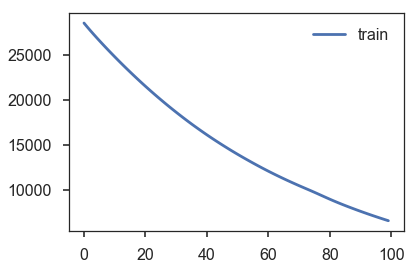

In [227]:
plt.plot(hist.history['loss'], label='train')
plt.legend()

In [228]:
X_te_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [229]:
res = model.predict(X_te_reshaped)
test_data["LSTM_PRED"] = res

/Users/qianyu/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [230]:
test_data.head()

,GHI,Precip_water,AOD,Month,T_1,T_2,T_3,T_4,T_5,RF_PREDICTED,LSTM_PRED
Datetime,,,,,,,,,,,
2005-01-02,49.44721,1.58929,0.10800,1,86.12898,95.93684,66.89699,109.08372,106.34229,88.37066,86.77110
2005-01-09,61.90325,1.46190,0.10800,1,49.44721,86.12898,95.93684,66.89699,109.08372,88.42723,86.53706
2005-01-16,110.09291,1.30476,0.10914,1,61.90325,49.44721,86.12898,95.93684,66.89699,97.57058,87.71140
2005-01-23,116.00597,1.44881,0.11057,1,110.09291,61.90325,49.44721,86.12898,95.93684,110.10964,87.70918
2005-01-30,104.46748,1.70238,0.11229,1,116.00597,110.09291,61.90325,49.44721,86.12898,84.05093,85.45808


In [231]:
keras_p = figure(width=900, height=350, x_axis_type="datetime")

# add renderers
keras_p.line(test_data.index, y=test_data.GHI, color = 'blue', legend='Test Data')
keras_p.line(test_data.index, y=test_data.RF_PREDICTED, color = 'red', legend='RF_Predict')
keras_p.line(test_data.index, y=test_data.LSTM_PRED, color = 'green', legend='LSTM_predict')
show(keras_p)

In [201]:
RMSE_lstm = np.sqrt(mean_squared_error(test_data.GHI, test_data.LSTM_PRED))
print "LSTM Model RMSE : {:.5f}".format(RMSE_lstm)

LSTM Model RMSE : 68.36667


### Using lag as time step

In [232]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(8, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [233]:
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

In [234]:
hist = model.fit(X_train_reshaped, y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 7s - loss: 38992.5148
Epoch 2/100
 - 4s - loss: 37724.0738
Epoch 3/100
 - 5s - loss: 37028.7347
Epoch 4/100
 - 4s - loss: 36407.5371
Epoch 5/100
 - 4s - loss: 35811.9012
Epoch 6/100
 - 4s - loss: 35231.6823
Epoch 7/100
 - 4s - loss: 34663.9359
Epoch 8/100
 - 4s - loss: 34108.4431
Epoch 9/100
 - 3s - loss: 33562.0688
Epoch 10/100
 - 5s - loss: 33021.8794
Epoch 11/100
 - 5s - loss: 32489.5839
Epoch 12/100
 - 5s - loss: 31964.0473
Epoch 13/100
 - 5s - loss: 31445.6062
Epoch 14/100
 - 4s - loss: 30935.6736
Epoch 15/100
 - 6s - loss: 30431.0902
Epoch 16/100
 - 4s - loss: 29931.3886
Epoch 17/100
 - 4s - loss: 29438.9865
Epoch 18/100
 - 5s - loss: 28953.2224
Epoch 19/100
 - 4s - loss: 28472.1868
Epoch 20/100
 - 5s - loss: 27997.9189
Epoch 21/100
 - 7s - loss: 27530.7812
Epoch 22/100
 - 6s - loss: 27069.3321
Epoch 23/100
 - 6s - loss: 26615.3354
Epoch 24/100
 - 11s - loss: 26166.4719
Epoch 25/100
 - 9s - loss: 25723.3427
Epoch 26/100
 - 7s - loss: 25287.1257
Epoch 27/100
 - 5s -

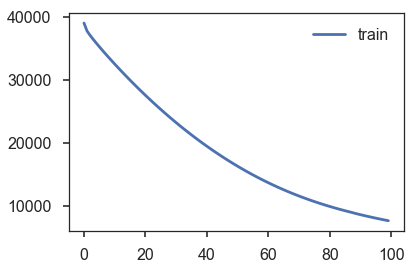

In [235]:
plt.plot(hist.history['loss'], label='train')
plt.legend()

In [238]:
X_te_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
res = model.predict(X_te_reshaped)
test_data["LSTM_PRED"] = res

/Users/qianyu/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [239]:
test_data.head()

,GHI,Precip_water,AOD,Month,T_1,T_2,T_3,T_4,T_5,RF_PREDICTED,LSTM_PRED
Datetime,,,,,,,,,,,
2005-01-02,49.44721,1.58929,0.10800,1,86.12898,95.93684,66.89699,109.08372,106.34229,88.37066,132.05920
2005-01-09,61.90325,1.46190,0.10800,1,49.44721,86.12898,95.93684,66.89699,109.08372,88.42723,131.44789
2005-01-16,110.09291,1.30476,0.10914,1,61.90325,49.44721,86.12898,95.93684,66.89699,97.57058,128.74654
2005-01-23,116.00597,1.44881,0.11057,1,110.09291,61.90325,49.44721,86.12898,95.93684,110.10964,130.70152
2005-01-30,104.46748,1.70238,0.11229,1,116.00597,110.09291,61.90325,49.44721,86.12898,84.05093,129.37419


In [240]:
keras_p = figure(width=900, height=350, x_axis_type="datetime")

# add renderers
keras_p.line(test_data.index, y=test_data.GHI, color = 'blue', legend='Test Data')
keras_p.line(test_data.index, y=test_data.RF_PREDICTED, color = 'red', legend='RF_Predict')
keras_p.line(test_data.index, y=test_data.LSTM_PRED, color = 'green', legend='LSTM_predict')
show(keras_p)

## Perform Difference Transformation